#### <center>Candidate 10046</center>

# <center> Numerical Mathematics Project 1</center>

In this project we look at underdetermined linear systems and two methods of obtaining a solution.\
In **task 1** we want to find the minimum norm solution (if it exists) using the lagrange function, and then reformulate our initial solution using QR decomposition, comparing the two methods.\
In **task 2** we use Tikhonov regularization, finding the least squares solution of a underdetermined system with a small norm. The solution we obtain from this method is a tradeoff between something that solves the system in the best possible way (i.e. is a minimizer of the least squares problem), and has the smallest norm. \
In **task 3** we apply our solutions to a single-channel source separation problem, wanting to separate a combined image of a 0 and a 1, using handed out bases for the images of 0 and 1. I have chosen to look for the minimum norm solution in this task.

## <center> Task 1 </center>
$\DeclareMathOperator{\rank}{rank}$ $\DeclareMathOperator{\argmin}{arg min}$
## a)

For linear systems of the form $A\mathbf x =\mathbf y, A\in\mathbb R^{2\times 3}, x\in\mathbb R^3, y\in\mathbb R^2$, \
we have no solutions if we let $\mathbf y=(3\quad 5)^T$ and $A = 
\begin{bmatrix} 1 & 2 & 4 \\ 2 & 4 & 8 \end{bmatrix}$

, and infinitely many solutions if we let $\mathbf y=(1\quad 1)^T$ and $A =  
\begin{bmatrix} 1 & 0 & 1 \\ 0 & 1 & 1 \end{bmatrix}$


In [1]:
# Importing code
import numpy as np
import scipy as sp
from numpy import linalg
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

#%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaPerformanceWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
"""
This is to remove a warning about the @ operator being more efficient for contiguous arrays,
which we do not have for some of our matrix/vector slices
"""
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

In [2]:
AInf = np.array([[1, 0, 1],
                 [0, 1, 1]])
yInf = np.array([1,
                 1])
ANan = np.array([[1,2,4],
                 [2,4,8]])
yNan = np.array([3,
                 5])

### b)
For $A\in\mathbb R^{m\times n}, m < n$, we have: \
$\left(A^TA\right)^T = A^TA^{T^T} = A^TA$, and likewise we get that for $AA^T$ \
$\left(AA^T\right)^T = A^{T^T}A^T = AA^T \implies$ $A^TA$ and $AA^T$ are symmetric. \
\
From the definition we get that a matrix $B$ is positive semi-definite if $\mathbf x^TB\mathbf x \geq 0 \quad\forall\quad\mathbf x \neq 0$ \
$\mathbf x^TA^TA\mathbf x = \left(A\mathbf x\right)^TA\mathbf x = \|A\mathbf x\|^2\geq 0$ \
$\mathbf x^TAA^T\mathbf x = \left(A^T\mathbf x\right)^TA^T\mathbf x = \|A^T\mathbf x\|^2 \geq 0 $ \
So $A^TA$ and $AA^T$ are both symmetric positive semi-definite. \
\
If $\rank(A) = m$, then $\exists\enspace x\in\mathbb R^n:A\mathbf x=\vec 0\implies\exists\enspace\mathbf x\in\mathbb R^n:A^TA\mathbf x=0\implies A^TA$ is not invertible. \
For $AA^T$, as it has **m** independend columns any linear combination of them is nonzero, which means that $\forall\enspace\mathbf x\neq\vec 0\enspace A^T\mathbf x\neq 0\implies\|A^T\mathbf x\|>\vec 0\implies AA^T\mathbf x\neq\vec 0,\enspace\forall\enspace\mathbf x\in\mathbb R^m\neq\vec 0$ and therefore, unlike $A^TA$, $AA^T$ is invertible by the previous calculations of their norms.

### c)
$\mathbf x_{min} = \argmin\enspace\mathbf x^T\mathbf x : A\mathbf x = \mathbf y$ (1) \
The Lagrange function corresponding to this problem is $\mathcal L(\mathbf x,\mathbf\lambda) = \mathbf x^T\mathbf x + \mathbf\lambda^T\left(A\mathbf x - \mathbf y\right)$ (2) \
Computing the gradients, we get: \
$\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda)_j = \frac{\partial}{\partial x_j}\sum_k x_k ^2 + \frac{\partial}{\partial x_j}\sum_i\lambda_i\sum_k a_{ik}x_k - \frac{\partial}{\partial x_j}\sum_k\lambda_k y_k = 2x_j + \sum_i\lambda_i a_{ij}\newline\implies\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda) = 2\mathbf x + A^T\mathbf\lambda$ \
$\nabla_{\mathbf\lambda}\mathcal L(\mathbf x,\mathbf\lambda) = \frac\partial{\partial\lambda_j}\sum_kx_k^2 + \frac\partial{\partial\lambda_j}\sum_i\lambda_i\sum_k a_{ik}x_k - \frac\partial{\partial\lambda_j}\sum_k\lambda_k y_k = \sum_k a_{jk}x_k - y_j\newline\implies\nabla_\mathbf\lambda\mathcal L(\mathbf x,\mathbf\lambda) = A\mathbf x - \mathbf y = \vec0$ \
Setting both gradients to zero, by (3), we set both gradients equal to each other to find lambda: \
$\begin{align}
\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda) &= \nabla_{\mathbf\lambda}\mathcal L(\mathbf x,\mathbf\lambda) \\
 2\mathbf x + A^T\mathbf\lambda &= \vec0 \\
 A^T\mathbf\lambda &= - 2\mathbf x \\
 AA^T\mathbf\lambda &= - 2A\mathbf x \\
 \mathbf\lambda &= - 2\left(AA^T\right)^{-1}A\mathbf x \\
 \mathbf\lambda &= -2\left(AA^T\right)^{-1}\mathbf y \\
\end{align}$

From our condition that $A\mathbf x = \mathbf y$, and our previous proof that $AA^T$ is invertible if $\rank(A) = m$, i.e. $A$ is of full rank, which is necessary to get a unique $\mathbf y$. \
Inserting this into $\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda)$, we get: \
$\begin{align}
\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda) &= 0 \\
 2\mathbf x + A^T\lambda &= 0 \\
 2\mathbf x - 2A^T\left(AA^T\right)^{-1}\mathbf y &=0 \\
 \textbf x_{min} &= A^T\left(AA^T\right)^{-1}\mathbf y
\end{align}$

### d)
As $A^T = QR$, $R$ is invertible (being upper triangular), and $Q$ is orthogonal: \
$\begin{align}
\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad\textbf x_{min} &= A^T\left(AA^T\right)^{-1}\mathbf y \\
 &= QR\left(\left(QR\right)^TQR\right)^{-1}\mathbf y \\
 &= QR\left(R^TQ^TQR\right)^{-1}\mathbf y \\
 &= QR\left(R^TR\right)^{-1}\mathbf y \\
 &= QRR^{-1}R^{-T}\mathbf y \\
 &= QR^{-T}\mathbf y
\end{align}$

In [3]:
# Calculating the reduced QR decomposition by Modified Gram-Schmidt
@jit(nopython=True)
def MGS_QR(A):
    m,n = np.shape(A)
    # Here i am using Q.T to optimize the dot products (contiguous arrays) so the rows of Q here are in fact columns
    Q = np.empty((n,m))
    R = np.zeros((n, n))
    for j in range(n):
        Q[j,:] = A[:,j]
        for i in range(j):
            # Calculating R and subtracting the projection of column i on column j from column j
            R[i,j] = np.dot(Q[i,:].T,Q[j,:])
            Q[j,:] -= R[i,j]*Q[i,:]

        R[j,j] = linalg.norm(Q[j,:])
        Q[j,:] /= R[j,j]
    return Q.T, R

### e)
We know that $\textbf x_{min} = QR^{-T}\textbf y$. \
Letting $\textbf z = R^{-T}\textbf y$, we get that $\textbf x_{min} = Q\textbf z$, and that $R^T\textbf z = \textbf y$,\
where we can find $\textbf z$ by forward substitution (as $R^T$ is lower triangular), and then $\textbf x_{min}$ by calculating $Q\textbf z$

In [4]:
# Finding x_min given y and QR decomposition of A^T using forward substitution
@jit(nopython=True)
def QR_solver(Q, R, y):
    RT = R.T
    n = RT.shape[0]
    z = np.zeros(n)
    for i in range(n):
        z[i]=(y[i]-np.dot(RT[i,:i],z[:i]))/RT[i,i]
    return np.dot(Q,z)

Testing this on the examples given in a), we get

In [5]:
QInf,RInf = MGS_QR(AInf.T)
xInf = QR_solver(QInf,RInf,yInf.T)
print('Minimum norm solution of Ainf x = yInf and solving back to show we indeed get yInf')
print(xInf)
print(AInf@xInf,'\n')
QNan,RNan = MGS_QR(ANan.T)
xNan = QR_solver(QNan,RNan,yNan.T)
print('Attempt at solving the system with no solutions using the minimum norm approach and QR decomposition')
print(xNan)
print(ANan@xNan)

Minimum norm solution of Ainf x = yInf and solving back to show we indeed get yInf
[0.33333333 0.33333333 0.66666667]
[1. 1.] 

Attempt at solving the system with no solutions using the minimum norm approach and QR decomposition
[1.07228563e+14 2.14457125e+14 4.28914250e+14]
[2.25179981e+15 4.50359963e+15]


### f)
Generating matrix $A \in \mathbb{R}^{m \times n}$

In [6]:
def generate_A(m,n):
    """
    Generates m times n with correlated columns.
    Input:
        m: int, first dimension of A
        n: int, second dimension of A
    output:
        A: (m,n) array
    """

    cov_eigvecs = np.random.uniform(-1.0,1.0,(m,m))
    cov = cov_eigvecs.T @ cov_eigvecs
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov == 0] = 0
    chol = sp.linalg.cholesky(corr, lower=True) 
    A = np.random.normal(0, 1.0,(m,n))
    A = np.dot(chol, A)
    return A

In [7]:
m = 2048
n = 8096
A = generate_A(m,n)

N = 100 # Number of test data we want to generate

# Generate solutions X columnwise, X[:,i] to access i-th vector
X = np.random.normal(0.0,1.0,(A.shape[1],N))

# Generate left hand sides Y columnwise Y[:,i] to access lhs
Y = np.dot(A,X)

# Doublecheck shapes
print(X.shape) # Expect (n,N)
print(Y.shape) # Expect (m,N)

(8096, 100)
(2048, 100)


First we time the precalculations of the methods involving np.linalg.solve and the QR method (method 1 and 2) independently, and then the calculations of $\mathbf x_{min}$ for all generated $\mathbf y$. \
Thereafter we will (with less accuracy) time the total amount spent on both precalculation and finding $\mathbf x_{min}$ for all generated $\mathbf y$.

In [8]:
%timeit -r 3 -n 1 AAT = np.dot(A, A.T)

908 ms ± 72.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [9]:
AAT = np.dot(A, A.T)

In [10]:
%%timeit -r 3 -n 1
for i in range(N):
    z = linalg.solve(AAT,Y[:,i])
    x_sol = np.dot(A.T,z)

25.3 s ± 268 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [11]:
%timeit -r 3 -n 1 Q,R = MGS_QR(A.T)

58.7 s ± 3.11 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [12]:
Q,R = MGS_QR(A.T)

In [13]:
%%timeit -r 3 -n 1
for i in range(N):
    x_qr = QR_solver(Q,R,Y[:,i])

3.7 s ± 137 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


From the timed results we find that calculating $AA^T$ is about 60 times faster than calculating the reduced QR decomposition, while finding $\mathbf x_{min}$ is almost 20 thousand times faster when we have calculated the QR decomposition than when we have calculated $AA^T$. Using the numbers obtained here we can roughly estimate that both methods take the same amount of time when we do the precalculations once and then find $\mathbf x_{min}$ for around 220 $\mathbf y$. If we need to solve the system more times than that the QR decomposition would be more efficient, and otherwise the other method would be better. This is of course for $A$ of dimension $2048\times8096$ and for the current level of optimization of these methods as the QR decomposition implemented here is not as optimized as the functions in the numpy library.

Now we are comparing both methods for the given case, i.e. we can precalculate $AA^T$ and the QR decomposition and then we want to solve 200 sets of equations using $A$

In [14]:
%%timeit -r 3 -n 1
AAT = np.dot(A, A.T)
for i in range(N):
    z = linalg.solve(AAT,Y[:,i])
    x_sol = np.dot(A.T,z)

26.5 s ± 615 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [15]:
%%timeit -r 3 -n 1
Q,R = MGS_QR(A.T)
for i in range(N):
    x_qr = QR_solver(Q,R,Y[:,i])

1min 2s ± 5.59 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


From this we see that method 1 using np.linalg.solve is about 2.3 times as fast in the given case, as calculating the QR decomposition is expensive, and we do not solve enough systems for us to save time using the QR decomposition.

In [16]:
avg_qr_acc = 0
avg_np_acc = 0
avg_np_qr_diff = 0

for i in range(N):
    x_qr = QR_solver(Q,R,Y[:,i])
    x_np = np.dot(A.T,np.linalg.solve(AAT,Y[:,i]))
    avg_qr_acc += linalg.norm(X[:,i]-x_qr)
    avg_np_acc += linalg.norm(X[:,i]-x_np)
    avg_np_qr_diff  += linalg.norm(x_np-x_qr)
    
avg_qr_acc /= N
avg_np_acc /= N
avg_np_qr_diff /= N
print(avg_qr_acc, avg_np_acc, avg_np_qr_diff)

77.88856027141088 77.88856027141088 4.767891564552704e-11


Here $\|\mathbf x_{min} - \mathbf x_{true}\| = 77.97$ on average. The solutions we find are identical independent of the method (which is good because they are unique as $\rank(A)=m$), but they are not the same $\mathbf x$ as the one we used to find our $\mathbf y$ because we originally just randomly generated $\mathbf x$, not caring about minimum norm. This means that we have no way of knowing how the $\mathbf x$ that generated any given $\mathbf y$ looks like and therefore we are unable to recover our solutions. We only know that $x_{true}\in D\subset\mathbb R^{m\times n}$ for some subset $D$ which is a linear combination of the columns of $A$.

## <center> Task 2 </center>
We now want to solve the same kind of underdetermined system using Tikhonov regularization (a.k.a. ridge regression).
### a)
Specifically, we want to find $\mathbf x_r = \argmin\|A\mathbf x -\mathbf y\|^2 + \mu\|\mathbf x\|^2 = \argmin T(\mathbf x),\enspace\mathbf x\in\mathbb R^n$.

Computing the gradient we get that: \
$\begin{align}
\nabla_\mathbf{x}T(\mathbf x_r)_j &= \frac\partial{\partial\mathbf{x}_j}\left(\sum_i\left(\sum_ka_{ik}\mathbf{x}_k-\mathbf{y}_i\right)^2+\mu\sum_k\mathbf{x}_k^2\right) \\
&= \frac\partial{\partial\mathbf{x}_j}\left(\sum_i\left(\left(\sum_ka_{ik}\mathbf{x}_k\right)^2+\mathbf{y}_i^2-2\mathbf{y}_i\sum_ka_{ik}\mathbf{x}_k\right)+\mu\sum_k\mathbf{x}_k^2\right) \\
&= 2\left(\sum_i\sum_ka_{ik}\mathbf{x}_ka_{ij}\right)-2\left(\sum_i\mathbf{y}_ia_{ij}\right)+2\mu\mathbf{x}_j \\
&= 2\left(\sum_ia_{ji}^T\sum_ka_{ik}\mathbf{x}_k\right)-2\left(\sum_ia_{ji}^T\mathbf{y}_i\right)+2\mu\mathbf{x}_j
\end{align}$ \
$\implies\nabla_\mathbf{x}T(\mathbf{x}_r) = 2A^TA\mathbf{x}_r-2A^T\mathbf y + 2\mu\mathbf{x}_r = 2\left(A^TA+\mu I\right)\mathbf{x}_r-2A^T\mathbf y$
As a solution $\mathbf x_{r}$ satisfies $\nabla_{\mathbf x}T(\mathbf x_r) = 0$, we get:\
$\left(A^TA+\mu I\right)\mathbf{x}_r=A^T\mathbf y$

In task 1 we have shown that $A^TA$ is positive semi-definite as $\mathbf{x}^TA^TA\mathbf{x}=\|A\mathbf x\|^2\geq0$. \
By the definition of positive semi-definite, \
$\mathbf{x}^T\left(A^TA+\mu I\right)\mathbf{x} = \mathbf{x}^TA^TA\mathbf{x}+\mathbf{x}^T\mu I\mathbf{x} = \|A\mathbf x\|^2+\mu\|\mathbf x\|^2>0\enspace\forall\enspace\mathbf{x}\neq\vec{0}$ by the properties of the l2-norm and as $\mu\geq0$. \
This gives us that $\left(A^TA+\mu I\right)$ is positive definite, and as we previously have shown that $A^TA$ is symmetric and we only add a constant along the diagonal it is also SPD and therefore invertible.

### b)
Using the SVD and the hint in the task description, we get that \
$\left(A^TA+\mu I\right) = V\Sigma U^TU\Sigma V^T + \mu VV^T = V\Sigma^2V^T + V\mu IV^T = V\left(\Sigma^2+\mu I\right)V^T=VD_0V^T$ \
As $\left(A^TA+\mu I\right)$ is invertible, $\mathbf{x}_r=\left(A^TA+\mu I\right)^{-1}A^T\mathbf y$. \
$\mathbf{x}_r=\left(VD_0V^T\right)^{-1}V\Sigma U^T\mathbf y =V^{-T}D_0^{-1}V^{-1}V\Sigma U^T\mathbf y=VD_0^{-1}\Sigma U^T\mathbf y = VDU^T\mathbf y$, where $D = \text{diag}\left(\frac{\Sigma_{kk}}{\Sigma_{kk}^2+\mu}\right)$, $k= 1,\ldots,m$


### c)

In [17]:
@jit(nopython=True)
def Tikhonov_solveSVD(U,S,Vt,mu,y):
    """
    Solves the Tikhonov regularization for a linear regularization parameter mu.
    Takes in the SVD of A and the parameter mu and returns the vector VDUt,
    which can be multiplied with y to find x_r as described earlier.
    The singular values S are taken in as a vector.
    """
    m = np.shape(U)[0]
    D = U.T.copy()
    D = D@y
    for k in range(m):
        D[k] *= S[k]/(S[k]*S[k]+mu)

    return Vt.T@D

### d)
Now we will solve a selected underdetermined system using the created framework (i.e. $A$, $\mathbf x$, $\mathbf x$) using Tikhonov regularization for various values of the regularization parameter $\mu$. First we select a system and create an array of values of $\mu$ to solve the system with. First we are timing how long it takes to solve the system using our SVD approach to the Tikhonov regularization.

In [18]:
mu_list = np.logspace(6,-6,num = 100)
errors_svd = np.zeros(100,dtype='f8')
x = X[:,69]
y = Y[:,69]

In [19]:
%%timeit -r 1 -n 1
U,S,Vt = np.linalg.svd(A,full_matrices = False)
for i in range(100):
    x_svd = Tikhonov_solveSVD(U,S,Vt,mu_list[i],y)
    errors_svd[i] = linalg.norm(x-x_svd)

47.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now we want to use the more general approach np.linalg.solve, precalculating $A^TA$ and $A^T\mathbf y$, and time this.

In [20]:
mu_list_np = np.logspace(6,-6,num = 10)
errors_np = np.zeros(10,dtype='f8')

In [21]:
%%timeit -r 1 -n 1
ATA = A.T@A
b = A.T@y
for i in range(10):
    x_r_np = linalg.solve((ATA+mu_list_np[i]*np.identity(n)),b)
    errors_np[i] = linalg.norm(x_r_np-x)

1min 48s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Plotting the difference between the solutions obtained with our two approaches, together with $\mathbf x_{min}$ obtained using the same methods as in task 1

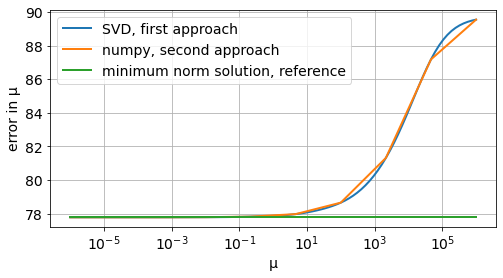

In [22]:
x_min_error_repeat = np.repeat(linalg.norm(x-QR_solver(Q,R,y)),10)
plt.plot(mu_list, errors_svd, label = "SVD, first approach")
plt.plot(mu_list_np, errors_np, label = "numpy, second approach")
plt.plot(mu_list_np, x_min_error_repeat, label = "minimum norm solution, reference")
plt.ylabel("error in μ")
plt.xlabel("μ")
plt.xscale("log")
plt.legend(loc=2)
plt.show()

We see from the plot that small mu (order $10^{1}$ and smaller) give the solutions closest to $\mathbf x_{true}$ and that $\|\mathbf x_r(\mu)-\mathbf x_{true}\|$ is the same regardless of whether $\mathbf x_r(\mu)$ was obtained using the SVD approach or the np.linalg.solve approach, which is desired as $\mathbf x_r(\mu)$ is supposed to be unique for a given $\mu$.
From the plot we also see that $\mathbf x_{min}$ actually is a minimizer to $\|\mathbf x_r(\mu)-\mathbf x_{true}\|$, which will always be the case if we actually have a solution to our system as the Tikhonov regularization tries to find a medium between a vector that is as close as possible to a solution and a vector with smallest possible norm.

## <center> Task 3 </center>
We now want to do some single channel source separation on images that are a mix of a set of images depicting zeros and another set of images depicting ones. To do this we have been handed out two sets of basis vectors (two matrices), one for each set of images. We want to separate the two images from our blended image by projecting the image onto our two bases using a projection matrix $B_i = I - W_iW_i^T$ for both of our bases $i=0, i=1 $.

### a)
For this $B$, and knowing that $W$ has pairwise orthogonal columns, we want to show that it is in fact a projection matrix and that it is symmetric positive semi-definite. \
$B$ is a projection matrix: \
$\begin{align}
B^2 &= \left(I-WW^T\right)\left(I-WW^T\right) \\
    &= I - 2WW^T + WW^TWW^T \\
    &= I - 2WW^T + WW^T \\
    &= I - WW^T \\
    &= B
\end{align}$ \
Here $W^TW$ cancels because $W$ has pairwise orthogonal columns.
$B$ is symmetric: \
$\begin{align}
B^T &= \left(I-WW^T\right)^T \\
    &= I - \left(WW^T\right)^T \\
    &= I - \left(W^T\right)^TW^T \\
    &= I - WW^T \\
    &= B
\end{align}$ \
$B$ is positive semi-definite: \
$B$ is positive semi definite if $\mathbf x^TB\mathbf x\geq0$ \
$\mathbf x^TB\mathbf x = \mathbf x^TBB\mathbf x = \left(B\mathbf x\right)^TB\mathbf x = \|B\mathbf x\|^2 \geq 0$, \
as $B^2=B$ and $B^T=B$

### b)
#### 1)
We want to find $\argmin\enspace\frac12\mathbf{x}^TB\mathbf x : A\mathbf x =\mathbf y$ \
Our Lagragian for this problem is: $\mathcal{L}(\mathbf x,\mathbf\lambda) = \frac12\mathbf{x}^TB\mathbf x + \mathbf\lambda^T\left(A\mathbf x - \mathbf y\right)$, and we know that $\nabla_{\mathbf{x}}\mathcal{L}(\mathbf x,\mathbf\lambda)=0$, and $\nabla_{\mathbf\lambda}\mathcal{L}(\mathbf x,\mathbf\lambda)=0$ for a solution $\mathbf{x}_{min}$. \
From our previous calculations we know that $\nabla_{\mathbf\lambda}\mathcal{L}(\mathbf x,\mathbf\lambda)=0\implies A\mathbf x = \mathbf y$, and calculating the other gradient we get: \
$\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda)_j 
= \frac{\partial}{\partial x_j}\frac12\sum_i\mathbf{x}_i\sum_k b_{ik}\mathbf{x}_k + \frac{\partial}{\partial x_j}\left(\sum_i\mathbf\lambda_i\sum_k a_{ik}\mathbf{x}_k -\sum_i\mathbf\lambda_i \mathbf{y}_i\right) 
= \frac12\left(\sum_i\mathbf{x}_ib_{ij}+\sum_kb{jk}\mathbf{x}_k\right) + \sum_i\mathbf\lambda_i a_{ij}$ \
$\implies \nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda) 
= \frac12 B^T\mathbf x+\frac12 B\mathbf x + A^T\mathbf\lambda$ \
$\nabla_{\mathbf x}\mathcal L(\mathbf x,\mathbf\lambda) = 0 
\implies \frac12 B^T\mathbf x+\frac12 B\mathbf x + A^T\mathbf\lambda = 0$ \
\
These equations give us this system: \
$\begin{bmatrix}\left(\frac12 B^T+\frac12 B\right) & A^T\\ A & 0\end{bmatrix}\begin{bmatrix}\mathbf x\\\mathbf\lambda\end{bmatrix}=\begin{bmatrix}0\\\mathbf y\end{bmatrix}$ \
\
For our system we know that: \
$B = \begin{bmatrix}B_0&0\\0&B_1\end{bmatrix}$, $B_n=I - W_nW_n^T$, $A = \begin{bmatrix}I&I\end{bmatrix}$, and $\mathbf x = \begin{bmatrix}\mathbf{u}\\\mathbf{v}\end{bmatrix}$\
\
As $B^T = B$ we can simplify the general system first and then insert our $B$, $A$, and $\mathbf x$, giving us: \
$\begin{bmatrix}B & A^T\\ A & 0\end{bmatrix}\begin{bmatrix}\mathbf x\\\mathbf\lambda\end{bmatrix}=\begin{bmatrix}0\\\mathbf y\end{bmatrix} = \begin{bmatrix}I-W_0W_0^T&0&I\\ 0&I-W_1W_1^T&I\\I&I&0\end{bmatrix}\begin{bmatrix}\mathbf u\\\mathbf v\\\mathbf\lambda\end{bmatrix}=\begin{bmatrix}0\\0\\\mathbf y\end{bmatrix} $ \
Which is the system we were asked to derive.
#### 2)
We now want to simplify this and solve it as a simple system of the form $C\mathbf u=\mathbf d$ by eliminating $\lambda$.\
Transforming this back into three equations, we get that $B_0\mathbf{u}+I\lambda=B_1\mathbf{v}+I\lambda=0$, and that $\mathbf{u}+\mathbf{v}=y$ (as we assumed from the beginning). Therefore we have: $B_0\mathbf{u}=B_1\left(\mathbf{y}-\mathbf{u}\right)=B_1\mathbf{y}-B_1\mathbf{u}\implies\left(B_0+B_1\right)\mathbf{u}=B_1\mathbf{y}\implies C\mathbf{u}=\mathbf{d}$, with $C=\left(B_0 + B_1\right)$, and $\mathbf d=B_1\mathbf y$.
So now we can solve our system separating the two channels by a projection onto our bases by solving the system $C\mathbf u=\mathbf d$, and then finding $\mathbf v=\mathbf y-\mathbf u$.

#### 3)
Let us now solve the system $C\mathbf u=\mathbf d$

$\mathbf{y}^TC\mathbf y = \mathbf{y}^T\left(B_0+B_1\right)\mathbf y = \|B_0\mathbf{y}\|^2 + \|B_1\mathbf{y}\|^2 > 0$ as o.w. $\mathbf{y}$ would have to be in the kernel of both $B_1$ and $B_0$ which is impossible $\forall\enspace\mathbf y\neq 0$ as $\mathbf{y}=\mathbf{u}+\mathbf{v}$ and $B_0$, $B_1$ are "bases" for $\mathbf u$ and $\mathbf{v}$ respectively.

As C also is symmetric (sum of two symmetric matrices), $C$ is SPD and invertible, and therefore $C\mathbf u = \mathbf d$ only has one solution for $\mathbf d\neq 0$. If $\mathbf d = 0$ and $\mathbf y\neq 0$, we must have that $B_1\mathbf y = 0\implies\mathbf y = \mathbf u$, which we may in the theoretical perfect case that $B_0\perp B_1$ and if $\mathbf y = \mathbf u$. As we assume $\mathbf y\neq 0$, we before solving check if $\|B_1\mathbf{y}\| = 0$ (the norm is smaller than some value, e.g. $10^{-6}$) and if this is true set $\mathbf{u}_{min}=\mathbf{y}$ and $\mathbf{v}=0$. Adding this check we have a system with a unique solution giving us $\mathbf x_{min}=\mathbf u_{min} + \mathbf v_{min}$.

This is fast for our case as we can precalculate $B_0$ and $B_1$ and simply have to solve one equation for each $\mathbf y$.

In [23]:
def source_separation(C, B1, y):
    d = B1@y
    if linalg.norm(y) < 10**(-6) or linalg.norm(d) < 10**(-6):
        return y
    else:
        return linalg.solve(C,d)

### d)
Now we want to test our single channel source separation solver for our set of 100 mixed images using the handed out code. \
First we display two examples of our mixed images. \
Second we display the first basis vector for our basis of the set of images containing zeros together with the product $W_0^TW_0$, which should be an identity matrix of dimension $16\times 16$ as our basis vectors are pairwise orthogonal and we have 16 of these basis vectors. \
Finally, we time how long our solution takes to separate all our 100 mixed images and display an example of a mixed image together with its separation, the vectors $\mathbf u$ and $\mathbf v$ (reshaped into matrices to render an image).

(784, 100)
(784, 16)
(784, 16)


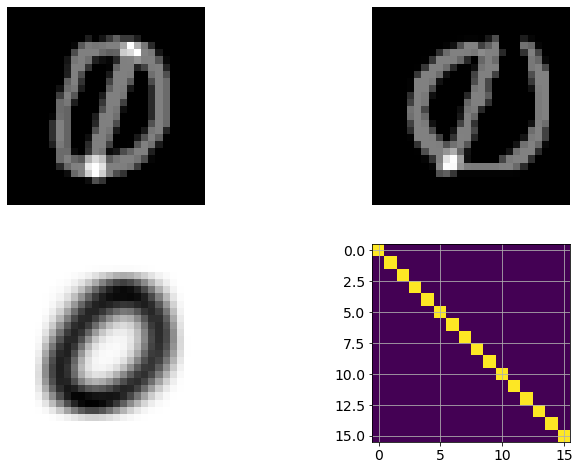

In [24]:
# Loading our mixed images
Mixes = np.load('C:/Users/maxka/Documents/NumMatProject1Data/Data/mixed.npy')
print(Mixes.shape) # Should be (784,100)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(Mixes[:,1].reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image

plt.subplot(2,2,2)
plt.imshow(Mixes[:,32].reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image

# Loading our bases
W0 = np.load('C:/Users/maxka/Documents/NumMatProject1Data/Data/W0.npy')
W1 = np.load('C:/Users/maxka/Documents/NumMatProject1Data/Data/W1.npy')
print(W0.shape) # Should be (784,16)
print(W1.shape) # Should be (784,16)

plt.subplot(2,2,3)
plt.imshow(W0[:,0].reshape((28,28)), cmap = 'gray')
plt.axis('off')
plt.subplot(2,2,4)
W0TW0 = np.dot(W0.T, W0)
plt.imshow(W0TW0)
plt.show()

In [25]:
%%timeit -r 5
B1 = np.identity(np.shape(W1)[0]) - W1@W1.T
C = np.identity(np.shape(W0)[0]) - W0@W0.T + B1

dim = np.shape(Mixes)
u = np.zeros(dim)
v = np.zeros(dim)

for i in range(dim[1]):
    y = Mixes[:,i]
    u[:,i] = source_separation(C, B1, y)
    v[:,i] = y - u[:,i]

1.52 s ± 30.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


We see that the single channel source separation is very fast as the images are much smaller than the matrix $A$ in task 1.

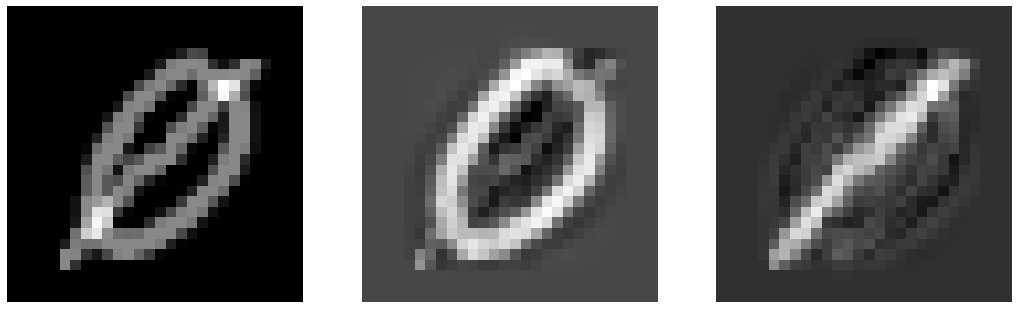

In [26]:
# We have to create these outside our timed cell to store the solution
B1 = np.identity(np.shape(W1)[0]) - W1@W1.T
C = np.identity(np.shape(W0)[0]) - W0@W0.T + B1

dim = np.shape(Mixes)
u = np.zeros(dim)
v = np.zeros(dim)

y = Mixes[:,69]
u = source_separation(C, B1, y)
v = y - u
plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(y.reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image

plt.subplot(1,3,2)
plt.imshow(u.reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image

plt.subplot(1,3,3)
plt.imshow(v.reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image
plt.show()

We get a fairly clear separation of the 0 and 1 in the combined image, with some background noise of the mixed image remaining, which we possibly could minimize by scaling the values of the separated images such that the largest values are completely white and the smallest values are completely black. A simple implementation could be choosing a factor and multiplying/dividing all values greater/smaller than som midpoint by this value and then capping all values to the maximum/minimum for white/black, which I would identify as the largest weakness of the current implementation. \

The single channel source separation implemented here gives a satisfactory result with relatively cheap computation so it definitely works as intended. This works in this case as the zeros and ones are sufficiently different to create bases that are orthogonal enough to each other to get images of the clarity we just plotted. If the two channels were more similar we would struggle to separate them using this approach, but this is true in the general case. Overall we have a successful separation of our two sets of images.